In [1]:
#Yoann normal 

In [1]:
import sys,os
import tarfile
import numpy as np
import pandas as pd
import xarray as xr
import time as tm

import SDFC.link as sdl
import NSSEA as ns
import NSSEA.plot as nsp
import NSSEA.models as nsm

In [2]:
#Useful modified
def correct_miss( X , lo =  100 , up = 350 ):##{{{
#	return X
	mod = str(X.columns[0])
	bad = np.logical_or( X < lo , X > up )
	bad = np.logical_or( bad , np.isnan(X) )
	bad = np.logical_or( bad , np.logical_not(np.isfinite(X)) )
	if np.any(bad):
		idx,_ = np.where(bad)
		idx_co = np.copy(idx)
		for i in range(idx.size):
			j = 0
			while idx[i] + j in idx:
				j += 1
			idx_co[i] += j
		X.iloc[idx] = X.iloc[idx_co].values
	return X
##}}}

def load_models_CMIP6(pathInp,type_data):
    ## List of models X
    pathInpX= os.path.join(pathInp,"CMIP6/X",type_data)
    modelsX = [  "_".join(f.split("/")[-1][:-3].split("_")[-2:]) for f in os.listdir(pathInpX) ]
    modelsX.sort()

    ## List of models Y
    pathInpY= os.path.join(pathInp,"CMIP6/Y",type_data)
    modelsY = [ "_".join(f.split("/")[-1][:-3].split("_")[-2:]) for f in os.listdir(pathInpY) ]
    modelsY.sort()
    models = list(set(modelsX) & set(modelsY))
    models.sort()
    print(models)


    ## Load X and Y
    lX = []
    lY = []
    if type_data== "03_Post_treatment":
    	
    	for m in models:
		
        	## Load X
        
        	df   = xr.open_dataset( os.path.join( pathInpX , "full_Europe_tas_YearMean_ssp585_{}.nc".format(m) ) ,decode_times=True )
        	time = df.time["time.year"].values.astype(int)
        	X    = pd.DataFrame( df.tas.values.ravel() , columns = [m] , index = time )
        	
        	lX.append( correct_miss(X , lo =  -15 , up = 25))
    
        	## Load Y
        	df   = xr.open_dataset( os.path.join( pathInpY , "full_Tricastin_ssp585_{}.nc".format(m) ) ,decode_times=True  )
        	time = df.time["time.year"].values.astype(int)
        	Y    = pd.DataFrame( df.tasmax.values.ravel() , columns = [m] , 	index = time )
        	lY.append( correct_miss(Y, lo =  -15 , up = 25 ))
    else:
    	for m in models:

        	## Load X
        
        	df   = xr.open_dataset( os.path.join( pathInpX , "full_Europe_tas_YearMean_ssp585_{}.nc".format(m) ) ,decode_times=False )
        	time = df.time.values.astype(int)
        	X    = pd.DataFrame( df.tas.values.ravel() , columns = [m] , index = time )
    
        	lX.append( correct_miss(X) )
    
        	## Load Y
        	df   = xr.open_dataset( os.path.join( pathInpY , "full_Tricastin_ssp585_{}.nc".format(m) ) ,decode_times=False  )
        	time = df.time.values.astype(int)
        	Y    = pd.DataFrame( df.tasmax.values.ravel() , columns = [m] , 	index = time )
        	lY.append( correct_miss(Y) )
    return lX, lY,models
    

def load_obs(pathInp,type_data):
    ## Load Observations
    dXo = xr.open_dataset(os.path.join( pathInp ,"Observations",type_data,"Xo.nc"))
    Xo  = pd.DataFrame( dXo.tas.values.squeeze() , columns = ["Xo"] , index = dXo.time["time.year"].values )

    Xo #Deja en anomalies
    dYo = xr.open_dataset(os.path.join( pathInp ,"Observations",type_data,"Yo.nc"))
    Yo  = pd.DataFrame( dYo.TX.values.squeeze() , columns = ["Yo"] , index = dYo.time["time.year"].values )
    return Xo,Yo #en celsius

In [3]:
#Parameters
time_period    = np.arange( 1850 , 2101 , 1 , dtype = int )
time_reference = np.arange( 1986 , 2016 , 1 , dtype = int )

ci          = 0.05
sample_dis=False #If want n sample of each GCM model. For graph only, not used for multisynthesis. Takes a lot of time

#Time period of interest
T=100
T1=2000
T2=2100
deb=1850
fin=2101

ns_law      = nsm.GEV()
event       = ns.Event( "HW19" , 2019 , time_reference , type_ = "value" , variable = "TX3X" , unit = "K" )
verbose     = "--not-verbose" not in sys.argv

In [4]:
pathInp='/home/barbauxo/Documents/Doctorat/03_Travail/2023_01 Application Tricastin/Data'
type_data="03_Post_treatment"  #"02_Selected"
lX,lY,models=load_models_CMIP6(pathInp,type_data)
Xo,Yo=load_obs(pathInp,type_data)
event.value = float(Yo.loc[event.time])

n_sample    = 10
verbose=False

['ACCESS-CM2_i1p1f1', 'ACCESS-ESM1-5_i1p1f1', 'CMCC-ESM2_i1p1f1', 'CNRM-CM6-1-HR_i1p1f2', 'CNRM-CM6-1_i1p1f2', 'CNRM-ESM2-1_i1p1f2', 'CanESM5_i1p2f1', 'EC-Earth3-CC_i1p1f1', 'EC-Earth3-Veg-LR_i1p1f1', 'EC-Earth3-Veg_i1p1f1', 'EC-Earth3_i1p1f1', 'FGOALS-g3_i1p1f1', 'GFDL-ESM4_i1p1f1', 'HadGEM3-GC31-LL_i1p1f3', 'HadGEM3-GC31-MM_i1p1f3', 'INM-CM4-8_i1p1f1', 'INM-CM5-0_i1p1f1', 'IPSL-CM6A-LR_i1p1f1', 'KACE-1-0-G_i1p1f1', 'MIROC-ES2L_i1p1f2', 'MIROC6_i1p1f1', 'MPI-ESM1-2-LR_i1p1f1', 'MRI-ESM2-0_i1p1f1', 'MRI-ESM2-0_i2p1f1', 'NESM3_i1p1f1', 'NorESM2-MM_i1p1f1', 'TaiESM1_i1p1f1', 'UKESM1-0-LL_i1p1f2']


In [7]:
## Prior Functions (Yoann this is so slow)
##================================
t0 = tm.time()
clim_Yoann = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim_Yoann.time , n_sample + 1 , fix_first = 0 )
clim_Yoann =ns.covariates_FC_GAM( clim_Yoann , lX ,  Xebm , dof = 7 , verbose = False )
clim_Yoann = ns.nslaw_fit( lY , clim_Yoann , verbose = verbose ) 
clim_Yoann = ns.infer_multi_model( clim_Yoann , verbose = verbose )
## Add constraint on X
clim_light_MM_Yoann = clim_Yoann.copy()
clim_light_MM_Yoann.keep_models( "Multi_Synthesis" )
clim_CX_Yoann     = ns.constrain_covariate( clim_light_MM_Yoann , Xo , time_reference , verbose = verbose )
t1 = tm.time()
total = t1-t0
print(total)
clim_CX_Yoann.to_netcdf( "clim_CX_Yoann.nc")

KeyboardInterrupt: 

In [28]:
clim_CX_Yoann=ns.Climatology.from_netcdf( "clim_CX_Yoann.nc" , ns_law ) 

In [6]:
bayes_kwargs = { "n_mcmc_drawn_min" :  5000 , "n_mcmc_drawn_max" : 10000 ,"n_ess"   : 10, "burn_in" : 500      }

bayes_kwargs["transition_type"]="Adapt"
bayes_kwargs["method_MCMC"]="bayesian-experimental-mhwg"
climCXCB   = ns.constrain_law( clim_CX_Yoann , Yo , verbose = verbose , **bayes_kwargs )

Adapt
[ 2.06703824e-01  1.59974531e+00  5.73028377e-01  9.14550903e-04
 -3.27155392e-01]
2.652350439502496
<class 'numpy.float64'>
0.5725754385964912
3.734845039372007
0.5725754385964912
[-0.67461696  1.05145594  0.55054521 -0.01685291 -0.33808157]
3.303127468058592
<class 'numpy.float64'>


/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:87: RuntimeWarning: overflow encountered in exp
  return np.exp( self.s * x) + self.b
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:93: RuntimeWarning: overflow encountered in exp
  return self.s * np.exp(self.s * x)
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/__AbstractLaw.py:514: RuntimeWarning: invalid value encountered in scalar subtract
  p_accept = np.exp( p_next - p_current )


0.0
3.303127468058592
0.0
[-0.31055127  1.27503937  0.43395034  0.10244056 -0.23693504]
4.814848513489778
<class 'numpy.float64'>


/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/NSSEA/NSSEA/models/__AbstractModel.py:114: SyntaxWarning: invalid escape sequence '\m'
  self.name_tex = "\mathrm{" + self.name + "}"


KeyboardInterrupt: 

In [ ]:
#Mine

In [5]:
from datetime import datetime
now = datetime.now()
 
# dd/mm/YY H:M:S
#dt_string = now.strftime("%m%d%H%M")
dt_string="11281101"
np.random.seed(int(dt_string))

In [6]:
%run "/home/barbauxo/Documents/Doctorat/03_Travail/2023_08 Clean Run/Utils/01Charge_Utils.py"

Number of processors:  8


In [7]:
#Bayes arg

n_sample    = 100 #N tirage X
burn_in=1000
n_val_MCMC=10 #Number kept from each MCMC (Total tirages Kept =1000)
time_period    = np.arange( 1850 , 2101 , 1 , dtype =int) #np.int )
time_reference = np.arange( 1986 , 2016 , 1 , dtype =int)# np.int )

ci          = 0.05
sample_dis=False #If want n sample of each GCM model. For graph only, not used for multisynthesis. Takes a lot of time

#Time period of interest
T=100
T1=2000
T2=2100
deb=1850
fin=2101


## Some global parameters
##=======================

#bayes_kwargs = { "n_mcmc_drawn_min" :  5000 , "n_mcmc_drawn_max" : 10000 }
 
#test
#ns_law      =nsm.GEV(shape_cst = False )
ns_law      = nsm.GEV()
event       = ns.Event( "HW19" , 2019 , time_reference , type_ = "value" , variable = "TX3X" , unit = "K" )
verbose     = "--not-verbose" not in sys.argv

#Load Data (Post-treatment and anomaly)

lX,lY,models=load_models_CMIP6(pathInp,type_data)
Xo,Yo=load_obs(pathInp,type_data)
event.value = float(Yo.loc[event.time])
verbose= False

['ACCESS-CM2_i1p1f1', 'ACCESS-ESM1-5_i1p1f1', 'CMCC-ESM2_i1p1f1', 'CNRM-CM6-1-HR_i1p1f2', 'CNRM-CM6-1_i1p1f2', 'CNRM-ESM2-1_i1p1f2', 'CanESM5_i1p2f1', 'EC-Earth3-CC_i1p1f1', 'EC-Earth3-Veg-LR_i1p1f1', 'EC-Earth3-Veg_i1p1f1', 'EC-Earth3_i1p1f1', 'FGOALS-g3_i1p1f1', 'GFDL-ESM4_i1p1f1', 'HadGEM3-GC31-LL_i1p1f3', 'HadGEM3-GC31-MM_i1p1f3', 'INM-CM4-8_i1p1f1', 'INM-CM5-0_i1p1f1', 'IPSL-CM6A-LR_i1p1f1', 'KACE-1-0-G_i1p1f1', 'MIROC-ES2L_i1p1f2', 'MIROC6_i1p1f1', 'MPI-ESM1-2-LR_i1p1f1', 'MRI-ESM2-0_i1p1f1', 'MRI-ESM2-0_i2p1f1', 'NESM3_i1p1f1', 'NorESM2-MM_i1p1f1', 'TaiESM1_i1p1f1', 'UKESM1-0-LL_i1p1f2']


In [8]:
t0 = tm.time()





## Define clim variable from input
##================================
clim0 = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim0.time , n_sample + 1 , fix_first = 0 )
clim1 =covariates_FC_GAM_pygam_light( clim0 , lX ,  Xebm , dof = 7 , verbose = False )
clim2 = nslaw_fit_light( lY , clim1 , verbose = verbose ) 
clim3 = infer_multi_model_light( clim2 , verbose = verbose )
## Add constraint on X
clim_light_MM = clim3.copy()
clim_light_MM.keep_models( "Multi_Synthesis" )
clim_CX     = ns.constrain_covariate( clim_light_MM , Xo , time_reference , verbose = verbose )
clim_CX.to_netcdf(  ("clim_CX_"+dt_string+"b.nc")   )
t1 = tm.time()
total = t1-t0
print(total)
clim_CX.law_coef.loc[:,"BE",:]


[[[-0.43705247 -0.43849886 -0.91380719 ... -0.09016614  0.17849804
   -0.51347476]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.44305295 -0.43684794 -0.92489502 ... -0.10465836  0.18247936
   -0.51434518]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.44436991 -0.43061105 -0.93371135 ... -0.11331356  0.19418479
 

[-4.95778191e-01 -4.93758181e-01 -4.86909428e-01 -4.82588104e-01
 -4.78813059e-01 -4.82385140e-01 -5.75100172e-01 -6.96488079e-01
 -7.13314306e-01 -6.82172751e-01 -6.41025778e-01 -6.04585431e-01
 -6.05676786e-01 -5.97813519e-01 -5.82191826e-01 -5.63369454e-01
 -5.47026280e-01 -5.33787970e-01 -5.23998122e-01 -5.15852185e-01
 -5.11942868e-01 -5.03973418e-01 -4.99251902e-01 -5.00323367e-01
 -5.00301156e-01 -4.99541797e-01 -5.12482406e-01 -5.20556603e-01
 -5.22936292e-01 -5.22925702e-01 -5.20350807e-01 -5.15553802e-01
 -5.13369371e-01 -6.23723205e-01 -9.34575527e-01 -9.81870351e-01
 -9.55943015e-01 -9.41607304e-01 -8.96132760e-01 -8.79657744e-01
 -8.91992303e-01 -8.78494218e-01 -8.47435260e-01 -7.90247595e-01
 -7.31660591e-01 -6.82169815e-01 -6.88482181e-01 -6.93731626e-01
 -6.87047293e-01 -6.66044038e-01 -6.44332193e-01 -6.27318818e-01
 -6.60933323e-01 -8.11088801e-01 -8.25796836e-01 -7.94913791e-01
 -7.53703668e-01 -7.30692148e-01 -7.14392869e-01 -6.90388860e-01
 -6.70876500e-01 -6.56853

[-0.47139617 -0.48331997 -0.48817496 -0.49687028 -0.50644266 -0.52697625
 -0.67997596 -0.87558068 -0.91582271 -0.88476408 -0.83878576 -0.7997261
 -0.81633314 -0.81952201 -0.81104982 -0.79766799 -0.78779554 -0.78234182
 -0.78179742 -0.78346128 -0.79116515 -0.79256324 -0.79849281 -0.81271511
 -0.82497866 -0.8357926  -0.86658708 -0.88975798 -0.90405437 -0.91436573
 -0.92041368 -0.92268619 -0.92834668 -1.10069314 -1.57038831 -1.6479602
 -1.61617107 -1.6010106  -1.53897331 -1.51938727 -1.54195083 -1.52546068
 -1.48218741 -1.39939365 -1.31383228 -1.2411107  -1.250634   -1.25793037
 -1.24686241 -1.21389946 -1.17927659 -1.15103975 -1.19744079 -1.41642164
 -1.43361331 -1.38253001 -1.31557698 -1.27514939 -1.24419499 -1.2013079
 -1.16462163 -1.13563161 -1.17484631 -1.22101968 -1.20386202 -1.16158642
 -1.11670974 -1.07504685 -1.03677855 -1.01302832 -1.02316328 -1.02965395
 -1.01895971 -1.00381232 -0.99858623 -0.99127018 -0.97563931 -0.95616572
 -0.95504355 -0.97134232 -0.96544237 -0.96179356 -0.97

[-6.35978714e-02 -5.24224413e-02 -3.37929097e-02 -1.95110814e-02
 -6.39447765e-03 -5.35410825e-03 -1.47650729e-01 -3.36240210e-01
 -3.57307122e-01 -3.01668966e-01 -2.30244167e-01 -1.66638813e-01
 -1.63527080e-01 -1.46305047e-01 -1.16889558e-01 -8.25914949e-02
 -5.25229334e-02 -2.76842338e-02 -8.62424110e-03  7.55705279e-03
  1.67008945e-02  3.21255317e-02  4.21064909e-02  4.25624742e-02
  4.45480580e-02  4.74941781e-02  2.82363981e-02  1.65719358e-02
  1.38328879e-02  1.47205130e-02  1.95171527e-02  2.76760937e-02
  3.14424110e-02 -1.45587418e-01 -6.44566657e-01 -7.20785200e-01
 -6.79685242e-01 -6.57371525e-01 -5.85267816e-01 -5.59880611e-01
 -5.80900777e-01 -5.60636584e-01 -5.12359792e-01 -4.22316299e-01
 -3.30187519e-01 -2.52811260e-01 -2.65135754e-01 -2.75900705e-01
 -2.67654046e-01 -2.36563880e-01 -2.04467900e-01 -1.80036446e-01
 -2.36971742e-01 -4.81046745e-01 -5.07867779e-01 -4.61631540e-01
 -3.98923826e-01 -3.65516594e-01 -3.42971588e-01 -3.08149749e-01
 -2.80616134e-01 -2.61967

[ 1.51512798e-01  1.23161961e-01  1.01357840e-01  7.63228081e-02
  5.07194880e-02  1.55098777e-02 -1.38257317e-01 -3.29996295e-01
 -3.82179924e-01 -3.70183138e-01 -3.44559830e-01 -3.24887195e-01
 -3.54874442e-01 -3.72565923e-01 -3.79532768e-01 -3.81823760e-01
 -3.86983715e-01 -3.95822785e-01 -4.08776049e-01 -4.23416316e-01
 -4.43174908e-01 -4.56975540e-01 -4.74531433e-01 -4.99210464e-01
 -5.21814902e-01 -5.42796343e-01 -5.81366183e-01 -6.12766662e-01
 -6.35871236e-01 -6.55058775e-01 -6.70075006e-01 -6.81352629e-01
 -6.95309870e-01 -8.58375195e-01 -1.28771244e+00 -1.36504924e+00
 -1.34394149e+00 -1.33736109e+00 -1.28835722e+00 -1.27702708e+00
 -1.30309515e+00 -1.29373923e+00 -1.25995785e+00 -1.19032906e+00
 -1.11781755e+00 -1.05642680e+00 -1.06840184e+00 -1.07800283e+00
 -1.07076665e+00 -1.04353568e+00 -1.01446352e+00 -9.90772055e-01
 -1.03367316e+00 -1.23100180e+00 -1.24705920e+00 -1.20158030e+00
 -1.14156507e+00 -1.10503843e+00 -1.07671725e+00 -1.03741474e+00
 -1.00339917e+00 -9.76019

[-1.18833215e+00 -1.18719853e+00 -1.18020971e+00 -1.17618895e+00
 -1.17276038e+00 -1.17808133e+00 -1.29026321e+00 -1.43677443e+00
 -1.45780478e+00 -1.42123693e+00 -1.37260541e+00 -1.32955704e+00
 -1.33146437e+00 -1.32256889e+00 -1.30430535e+00 -1.28214096e+00
 -1.26288838e+00 -1.24729874e+00 -1.23578381e+00 -1.22617912e+00
 -1.22159503e+00 -1.21207982e+00 -1.20639912e+00 -1.20760644e+00
 -1.20744097e+00 -1.20633054e+00 -1.22159239e+00 -1.23095665e+00
 -1.23343053e+00 -1.23297702e+00 -1.22938761e+00 -1.22307273e+00
 -1.21983217e+00 -1.35151773e+00 -1.72363419e+00 -1.77956344e+00
 -1.74760590e+00 -1.72949331e+00 -1.67397123e+00 -1.65317424e+00
 -1.66687442e+00 -1.64953089e+00 -1.61106501e+00 -1.54119835e+00
 -1.46958945e+00 -1.40882283e+00 -1.41491784e+00 -1.41966204e+00
 -1.41001150e+00 -1.38310116e+00 -1.35525258e+00 -1.33294653e+00
 -1.37126976e+00 -1.54927920e+00 -1.56471925e+00 -1.52536472e+00
 -1.47351025e+00 -1.44336647e+00 -1.42115245e+00 -1.38957144e+00
 -1.36324784e+00 -1.34337

[-8.43951932e-01 -8.64369846e-01 -8.81322241e-01 -8.99846132e-01
 -9.18567436e-01 -9.42141825e-01 -1.02671435e+00 -1.13075414e+00
 -1.16277219e+00 -1.16161029e+00 -1.15331916e+00 -1.14798571e+00
 -1.16813308e+00 -1.18183100e+00 -1.18988752e+00 -1.19541759e+00
 -1.20230762e+00 -1.21097321e+00 -1.22163665e+00 -1.23304467e+00
 -1.24696439e+00 -1.25768554e+00 -1.27021178e+00 -1.28627665e+00
 -1.30113813e+00 -1.31502784e+00 -1.33784324e+00 -1.35682450e+00
 -1.37138875e+00 -1.38379077e+00 -1.39389728e+00 -1.40192984e+00
 -1.41119407e+00 -1.49714794e+00 -1.72016954e+00 -1.76163566e+00
 -1.75221220e+00 -1.75011644e+00 -1.72599690e+00 -1.72112964e+00
 -1.73536991e+00 -1.73118818e+00 -1.71425043e+00 -1.67867034e+00
 -1.64143858e+00 -1.60977476e+00 -1.61575922e+00 -1.62036397e+00
 -1.61613711e+00 -1.60145531e+00 -1.58567710e+00 -1.57252671e+00
 -1.59355196e+00 -1.69402166e+00 -1.70093839e+00 -1.67601026e+00
 -1.64346144e+00 -1.62289026e+00 -1.60642351e+00 -1.58417722e+00
 -1.56453703e+00 -1.54820

[-0.14582643 -0.16485154 -0.17865122 -0.19518746 -0.21229433 -0.23733152
 -0.35899927 -0.5116939  -0.55088982 -0.53795254 -0.51404038 -0.49509329
 -0.51669712 -0.52841497 -0.53152741 -0.53096077 -0.53285934 -0.53788409
 -0.5463916  -0.55640672 -0.57072566 -0.58033245 -0.59313624 -0.61188068
 -0.62907996 -0.64510413 -0.67559379 -0.70039586 -0.71859502 -0.73375785
 -0.74567885 -0.75471264 -0.76608589 -0.89900929 -1.24886891 -1.31232501
 -1.29580044 -1.29127035 -1.25237087 -1.24431308 -1.26687309 -1.26076846
 -1.23495443 -1.18013145 -1.12313283 -1.0753527  -1.08746196 -1.09779576
 -1.09457338 -1.07521971 -1.05450953 -1.03831793 -1.07647187 -1.24047631
 -1.25702825 -1.22360142 -1.17845502 -1.15253959 -1.13340823 -1.10543782
 -1.08186538 -1.06378559 -1.09537416 -1.13191937 -1.12211208 -1.09384842
 -1.06356838 -1.03551947 -1.00983645 -0.99463915 -1.00406931 -1.01073092
 -1.00474182 -0.99539535 -0.99319059 -0.98935814 -0.97935678 -0.96645179
 -0.96684871 -0.97986986 -0.97659292 -0.97486808 -0

47.55387210845947


<xarray.DataArray 'law_coef' (coef: 5, model: 1)>
array([[-0.41608544],
       [ 1.3994095 ],
       [ 0.56862676],
       [ 0.00334642],
       [-0.24385484]])
Coordinates:
  * model    (model) <U23 'Multi_Synthesis'
    sample   <U4 'BE'
  * coef     (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'

In [40]:
Xebm 

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
1850,-0.140499,-0.157768,-0.136586,-0.290113,-0.140499,-0.147593,-0.140499,-0.049149,-0.142248,-0.290113,...,-0.142248,-0.137216,-0.110318,-0.232532,-0.110318,-0.147593,-0.147593,-0.130298,-0.140499,-0.140499
1851,-0.137193,-0.155110,-0.135621,-0.287960,-0.137193,-0.145633,-0.137193,-0.047692,-0.131732,-0.287960,...,-0.131732,-0.134093,-0.107588,-0.219227,-0.107588,-0.145633,-0.145633,-0.129703,-0.137193,-0.137193
1852,-0.127656,-0.145475,-0.127295,-0.277304,-0.127656,-0.136973,-0.127656,-0.040454,-0.117390,-0.277304,...,-0.117390,-0.125420,-0.098802,-0.202268,-0.098802,-0.136973,-0.136973,-0.122168,-0.127656,-0.127656
1853,-0.121347,-0.139327,-0.122345,-0.270630,-0.121347,-0.131520,-0.121347,-0.036082,-0.106253,-0.270630,...,-0.106253,-0.119672,-0.093177,-0.188663,-0.093177,-0.131520,-0.131520,-0.117780,-0.121347,-0.121347
1854,-0.115717,-0.133851,-0.117900,-0.264597,-0.115717,-0.126616,-0.115717,-0.032245,-0.096371,-0.264597,...,-0.096371,-0.114560,-0.088223,-0.176475,-0.088223,-0.126616,-0.126616,-0.113843,-0.115717,-0.115717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,-0.064530,-0.067547,-0.060385,-0.175074,-0.064530,-0.047378,-0.064530,-0.022028,-0.042509,-0.175074,...,-0.042509,-0.048509,-0.059024,-0.095650,-0.059024,-0.047378,-0.047378,-0.073692,-0.064530,-0.064530
2097,-0.064205,-0.067119,-0.059999,-0.174160,-0.064205,-0.046979,-0.064205,-0.021996,-0.042403,-0.174160,...,-0.042403,-0.048155,-0.058786,-0.095325,-0.058786,-0.046979,-0.046979,-0.073321,-0.064205,-0.064205
2098,-0.063881,-0.066694,-0.059614,-0.173251,-0.063881,-0.046583,-0.063881,-0.021964,-0.042297,-0.173251,...,-0.042297,-0.047803,-0.058549,-0.095002,-0.058549,-0.046583,-0.046583,-0.072951,-0.063881,-0.063881
2099,-0.063560,-0.066271,-0.059233,-0.172347,-0.063560,-0.046191,-0.063560,-0.021932,-0.042191,-0.172347,...,-0.042191,-0.047454,-0.058313,-0.094679,-0.058313,-0.046191,-0.046191,-0.072584,-0.063560,-0.063560


In [11]:
clim_CX=ns.Climatology.from_netcdf( ("clim_CX_"+dt_string+".nc")  , ns_law ) 

In [14]:

bayes_kwargs = { "n_mcmc_drawn_min" :  5000 , "n_mcmc_drawn_max" : 10000 ,"n_ess"   : 10, "burn_in" : 500      }
bayes_kwargs["transition_type"]="Adapt"
bayes_kwargs["method_MCMC"]="bayesian-experimental-mhwg"
climCXCB   = ns.constrain_law( clim_CX , Yo , verbose = verbose , **bayes_kwargs )

Adapt
[ 0.11157492  1.13262087  0.51083218  0.05727158 -0.24177427]
4.665889485315627
<class 'numpy.float64'>
0.5861004814220466
4.134421417114768
0.5861004814220466
[-0.8918595   1.38514728  0.58626897  0.05137862 -0.25267997]
3.083171828323196
<class 'numpy.float64'>


/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:87: RuntimeWarning: overflow encountered in exp
  return np.exp( self.s * x) + self.b
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:93: RuntimeWarning: overflow encountered in exp
  return self.s * np.exp(self.s * x)
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/__AbstractLaw.py:514: RuntimeWarning: invalid value encountered in scalar subtract
  p_accept = np.exp( p_next - p_current )


0.0
3.083171828323196
0.0
[-5.37878836e-01  1.37111420e+00  7.93573554e-01 -1.07985336e-03
 -2.26308892e-01]
4.532272927004588
<class 'numpy.float64'>
0.0
4.532272927004588
0.0
[-0.80965442  1.37879612  0.85632153 -0.05349516 -0.31060863]
3.8277005126240278
<class 'numpy.float64'>
0.0
3.8277005126240278
0.0
[-0.27098645  1.18496482  0.54580683  0.00367166 -0.34589987]
4.425412255182053
<class 'numpy.float64'>
0.0
4.425412255182053
0.0
[-0.27116773  1.30172736  0.49024259  0.04421817 -0.22627152]
6.148216536674373
<class 'numpy.float64'>
0.0
6.148216536674373
0.0
[-0.27993657  1.30272017  0.51546104  0.08287582 -0.21471105]
5.2130842788952965
<class 'numpy.float64'>
0.0
5.2130842788952965
0.0
[-0.29742531  1.14826241  0.17320038  0.04757285 -0.20427595]
3.9938801233956873
<class 'numpy.float64'>
0.0
3.9938801233956873
0.0
[ 0.16110305  1.15822827  0.38248723  0.09918461 -0.26897438]
3.225248889894366
<class 'numpy.float64'>
0.0
3.225248889894366
0.0
[-0.23395562  0.84352923  0.60184217 

KeyboardInterrupt: 

            Yo
1985 -0.576667
1986 -0.076667
1987 -1.176667
1988 -1.976667
1989 -1.876667
1990  1.523333
1991 -1.376667
1992 -0.676667
1993 -0.276667
1994  1.123333
1995 -0.176667
1996 -3.176667
1997 -1.476667
1998  0.223333
1999 -2.376667
2000 -0.376667
2001 -1.676667
2002 -1.076667
2003  4.623333
2004  0.823333
2005  0.723333
2006  1.923333
2007  0.023333
2008 -1.176667
2009  1.923333
2010  0.323333
2011  2.323333
2012  2.523333
2013  0.023333
2014 -0.676667
2015  1.523333
2016 -1.176667
2017  1.823333
2018  1.923333
2019  4.223333
2020  3.523333
2021  1.623333
[-0.61895613 -0.57398417 -0.52547087 -0.4717205  -0.41577954 -0.36934543
 -0.42533503 -0.59835366 -0.58171657 -0.50582748 -0.42108216 -0.34456492
 -0.2735798  -0.20379488 -0.1371408  -0.07620368 -0.0223931   0.02670841
  0.06535206  0.10335034  0.13739232  0.17955493  0.22099703  0.26203847
  0.30292159  0.34383038  0.38490478  0.42625144  0.46795184  0.51006832
  0.55264867  0.5957296   0.63933932  0.6834994   0.72822621  0.7

/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:90: RuntimeWarning: invalid value encountered in log
  return np.log(x - self.b) / self.s
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:87: RuntimeWarning: overflow encountered in exp
  return np.exp( self.s * x) + self.b
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/link/__Univariate.py:93: RuntimeWarning: overflow encountered in exp
  return self.s * np.exp(self.s * x)
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/SDFC-python/SDFC/__AbstractLaw.py:221: RuntimeWarning: overflow encountered in multiply
  if n_it % 100 == 0: cov_ *= 2
/home/barbauxo/Documents/05_Autres Activités/2023_11_Transfert_Code_Yoann/NSSEA/NSSEA/models/__AbstractModel.py:114: SyntaxWarning: invalid escape sequence '\m'
  self.name_tex = "\mathrm{" + self.name + "}"


LinAlgError: SVD did not converge

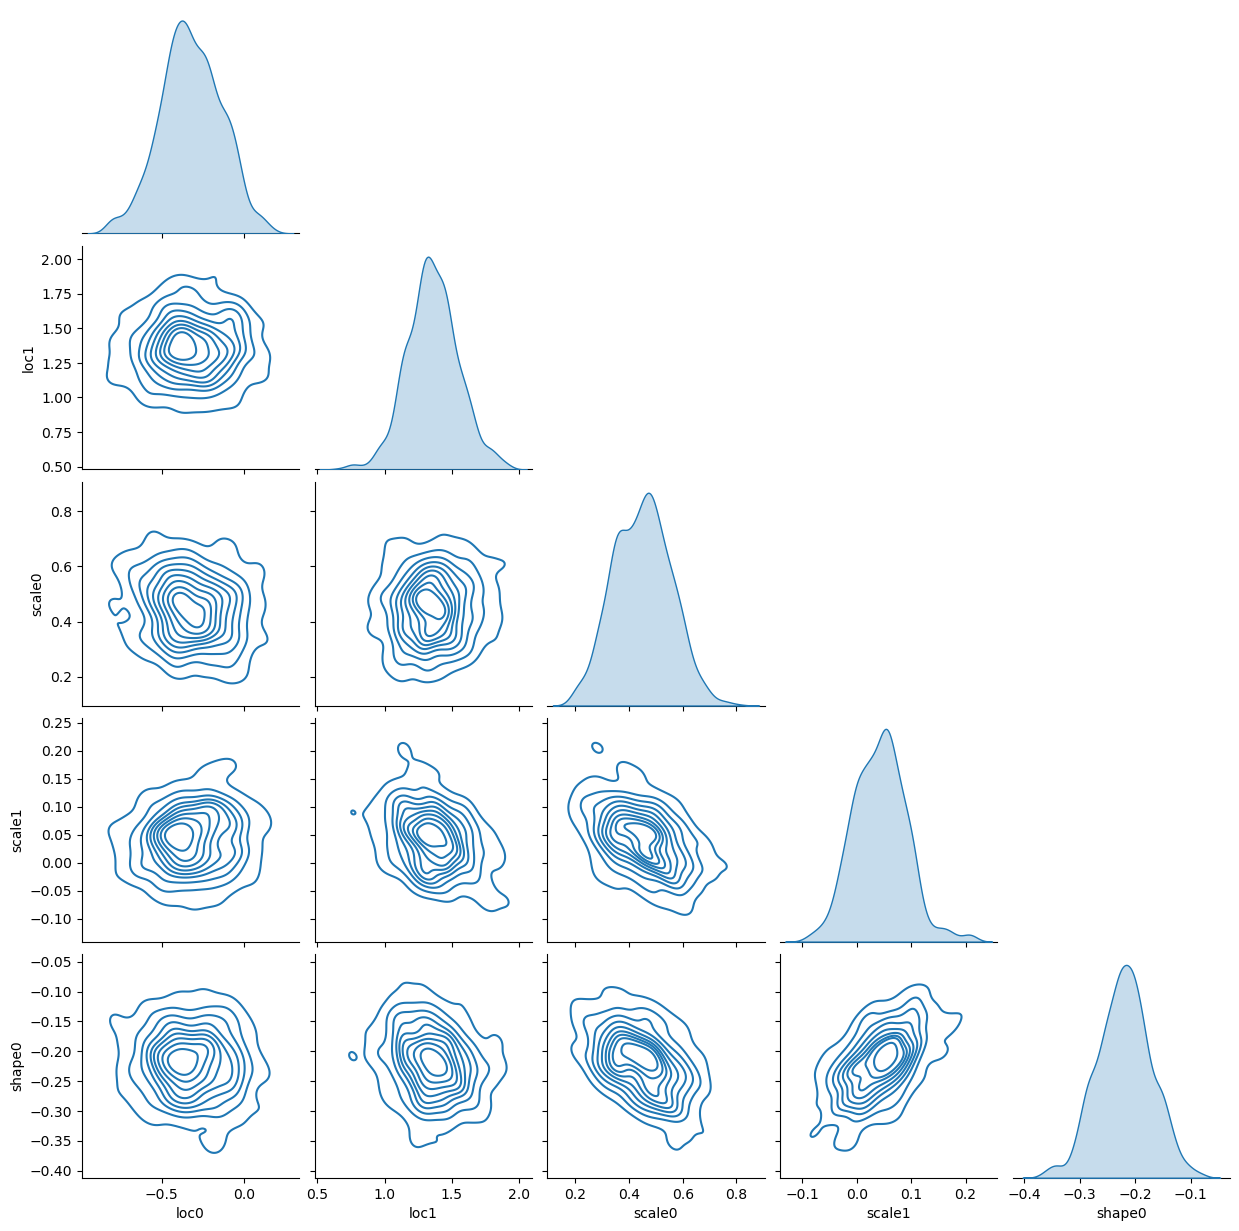

In [12]:
clim_CXCB_MHWG=constrain_MCMC_MHWG_law_all( clim_CX, Yo,""," ",TransitionAdapt=True,n_sortie=n_val_MCMC)


In [13]:
lX

[      ACCESS-CM2_i1p1f1
 1850          -0.612976
 1850          -0.524872
 1850          -0.566345
 1851          -0.931305
 1851           0.121521
 ...                 ...
 2099           7.428467
 2099           8.112823
 2100           7.888062
 2100           8.143555
 2100           7.910828
 
 [753 rows x 1 columns],
       ACCESS-ESM1-5_i1p1f1
 1850             -0.466156
 1850             -0.205292
 1850             -0.366425
 1850             -0.423340
 1850             -0.527435
 ...                    ...
 2100              6.987915
 2100              7.879852
 2100              6.263336
 2100              6.308838
 2100              6.142426
 
 [5644 rows x 1 columns],
       CMCC-ESM2_i1p1f1
 1850         -1.334106
 1851         -1.489075
 1852         -1.550354
 1853         -0.374298
 1854         -0.886047
 ...                ...
 2096          6.690582
 2097          6.222900
 2098          6.477753
 2099          6.737671
 2100          6.248169
 
 [251 rows x 1 colu

In [ ]:
clim_CX.X.loc[:,'BE',"F","Multi_Synthesis"].values

In [11]:
clim0 = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim0.time , n_sample + 1 , fix_first = 0 )
clim1 =covariates_FC_GAM_pygam_light( clim0 , lX ,  Xebm , dof = 7 , verbose = False )

In [12]:
clim1.X

<xarray.DataArray 'X' (time: 251, sample: 101, forcing: 2, model: 28)>
array([[[[-0.43705247, -0.43849886, -0.91380719, ..., -0.09016614,
           0.17849804, -0.51347476],
         [-0.43705247, -0.43849886, -0.91380719, ..., -0.09016614,
           0.17849804, -0.51347476]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
...
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * model    (model) <U23 'ACCESS-CM2_i1p1f1' ... 'UKESM1-0-LL_i1p1f2'
  * sample   (sample) <U4 'BE' 'S000' 'S001' 'S002' ... 'S097' 'S098' 'S099'
  * forcing  (forcing) <U1 'F' 'C'

In [13]:
clim2 = nslaw_fit_light( lY , clim1 , verbose = verbose ) 
clim2.X

<xarray.DataArray 'X' (time: 251, sample: 101, forcing: 2, model: 28)>
array([[[[-0.43705247, -0.43849886, -0.91380719, ..., -0.09016614,
           0.17849804, -0.51347476],
         [-0.43705247, -0.43849886, -0.91380719, ..., -0.09016614,
           0.17849804, -0.51347476]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
...
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * model    (model) <U23 'ACCESS-CM2_i1p1f1' ... 'UKESM1-0-LL_i1p1f2'
  * sample   (sample) <U4 'BE' 'S000' 'S001' 'S002' ... 'S097' 'S098' 'S099'
  * forcing  (forcing) <U1 'F' 'C'

In [14]:
clim3 = infer_multi_model_light( clim2 , verbose = verbose )
clim3.X


[[[-0.43705247 -0.43849886 -0.91380719 ... -0.09016614  0.17849804
   -0.51347476]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.44305295 -0.43684794 -0.92489502 ... -0.10465836  0.18247936
   -0.51434518]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.44436991 -0.43061105 -0.93371135 ... -0.11331356  0.19418479
 

[ 4.40101583e+08  6.07806309e+08  4.09246582e+09  5.85382488e+09
  1.42236992e+09 -4.38383891e+08  4.14075941e+09  4.87322125e+09
  2.07041463e+10  1.23512967e+09 -2.90733992e+10  5.46884500e+09
 -2.31404073e+09 -9.51884686e+09 -9.20623223e+09 -1.01162744e+10
  1.85482832e+10 -3.24271498e+10 -2.62140491e+10  2.83663302e+10
  1.77567572e+10  2.15829721e+10  2.24626884e+10  3.56070775e+10
  1.92477200e+10 -7.37099757e+09 -1.98701493e+10 -4.84888477e+09
 -1.26453052e+10  1.93588077e+09 -4.79254161e+09 -9.10322774e+09
 -1.02511196e+10 -9.76870481e+09 -2.02300907e+10  8.34226105e+09
 -2.17328100e+09  1.21916683e+10  9.44135940e+09 -2.58840859e+10
  1.64135891e+10 -2.76323381e+09 -1.24192141e+10 -9.61658227e+09
  7.76866689e+09 -8.72317944e+09  2.20976721e+10 -4.43105718e+09
  1.15899353e+10 -8.12453928e+09 -2.48409991e+09 -4.31022310e+10
  2.54516739e+08  7.39155478e+09 -2.02884457e+10 -9.76557503e+09
 -1.29551618e+09  1.33193394e+10 -2.24289387e+09 -5.07622388e+08
  1.91637220e+10  2.22760

[-1.53029860e+08 -2.07435491e+08 -1.37350720e+09 -1.96441596e+09
 -4.68872343e+08  1.28818044e+08 -1.38464748e+09 -1.63695905e+09
 -6.93754381e+09 -4.23738179e+08  9.74457031e+09 -1.82663600e+09
  7.88758638e+08  3.17287481e+09  3.06448713e+09  3.39128976e+09
 -6.22119560e+09  1.08692131e+10  8.76487137e+09 -9.51379436e+09
 -5.92878978e+09 -7.21966616e+09 -7.51083281e+09 -1.19129298e+10
 -6.46190087e+09  2.47477908e+09  6.63323344e+09  1.62448181e+09
  4.27343598e+09 -6.58824140e+08  1.60712327e+09  3.05243047e+09
  3.44718495e+09  3.26882594e+09  6.76728613e+09 -2.77927685e+09
  7.42429222e+08 -4.09508156e+09 -3.15896879e+09  8.68743855e+09
 -5.51015607e+09  9.19303394e+08  4.15066850e+09  3.23132682e+09
 -2.61124958e+09  2.89877723e+09 -7.41013583e+09  1.47311785e+09
 -3.89424675e+09  2.71605518e+09  8.30839966e+08  1.44531447e+10
 -8.43356395e+07 -2.46264951e+09  6.78041061e+09  3.26579083e+09
  4.42908359e+08 -4.44971738e+09  7.64911053e+08  1.92081760e+08
 -6.40509428e+09 -7.46407

[-5.71915760e+08 -7.43372864e+08 -4.88928479e+09 -6.99259362e+09
 -1.65737080e+09  4.23024978e+08 -4.91267919e+09 -5.82622289e+09
 -2.46814524e+10 -1.52334166e+09  3.46637433e+10 -6.47950518e+09
  2.83407315e+09  1.12619331e+10  1.08696976e+10  1.20583613e+10
 -2.21384817e+10  3.86686198e+10  3.11433350e+10 -3.38584420e+10
 -2.10601825e+10 -2.56567954e+10 -2.66979318e+10 -4.23432140e+10
 -2.30231800e+10  8.81909143e+09  2.35604639e+10  5.77826702e+09
  1.52672447e+10 -2.36870235e+09  5.72218650e+09  1.08634037e+10
  1.22824572e+10  1.16249954e+10  2.40452972e+10 -9.85219450e+09
  2.67343194e+09 -1.45870080e+10 -1.12266017e+10  3.09222880e+10
 -1.96181218e+10  3.26348763e+09  1.47470010e+10  1.15147823e+10
 -9.31037052e+09  1.02693193e+10 -2.63792632e+10  5.20476526e+09
 -1.38724047e+10  9.64867687e+09  2.94800523e+09  5.14342198e+10
 -3.02004172e+08 -8.72275974e+09  2.40924284e+10  1.15984978e+10
  1.59233569e+09 -1.57922654e+10  2.75064738e+09  7.32715250e+08
 -2.27538737e+10 -2.65373

[-9.39350116e+08 -1.19667477e+09 -7.78221050e+09 -1.11291754e+10
 -2.60502552e+09  5.97798159e+08 -7.79581831e+09 -9.27783605e+09
 -3.92423357e+10 -2.46138532e+09  5.51207551e+10 -1.02746787e+10
  4.56211334e+09  1.78397624e+10  1.72011725e+10  1.91744212e+10
 -3.52214687e+10  6.14927514e+10  4.94373891e+10 -5.38673629e+10
 -3.34010542e+10 -4.07401333e+10 -4.23859629e+10 -6.72466371e+10
 -3.66610401e+10  1.40443404e+10  3.73614101e+10  9.18576744e+09
  2.44211115e+10 -3.81023994e+09  9.10404598e+09  1.72808973e+10
  1.95768161e+10  1.84665768e+10  3.81802947e+10 -1.55964037e+10
  4.31117473e+09 -2.32331121e+10 -1.78292647e+10  4.92185492e+10
 -3.12322612e+10  5.16396072e+09  2.34031141e+10  1.83457024e+10
 -1.48386007e+10  1.62294354e+10 -4.19674307e+10  8.22156673e+09
 -2.20996489e+10  1.53140119e+10  4.67883849e+09  8.18188651e+10
 -4.77965503e+08 -1.38057589e+10  3.82341510e+10  1.84111955e+10
  2.56794595e+09 -2.50486841e+10  4.43008757e+09  1.25860735e+09
 -3.61095963e+10 -4.21852

[ 6.12460074e+08  8.00316095e+08  5.26336974e+09  7.52756834e+09
  1.78390615e+09 -4.56518371e+08  5.28995271e+09  6.27252481e+09
  2.65692973e+10  1.63979699e+09 -3.73165543e+10  6.97681682e+09
 -3.04967040e+09 -1.21233925e+10 -1.17012397e+10 -1.29822283e+10
  2.38324924e+10 -4.16273226e+10 -3.35271471e+10  3.64486220e+10
  2.26709528e+10  2.76207239e+10  2.87397451e+10  4.55836998e+10
  2.47817044e+10 -9.49244368e+09 -2.53623639e+10 -6.22034486e+09
 -1.64338311e+10  2.54838093e+09 -6.15942000e+09 -1.16941969e+10
 -1.32220101e+10 -1.25137473e+10 -2.58866520e+10  1.06075497e+10
 -2.87621204e+09  1.57023493e+10  1.20860488e+10 -3.32887552e+10
  2.11189376e+10 -3.51255242e+09 -1.58754626e+10 -1.23947321e+10
  1.00212159e+10 -1.10558554e+10  2.83956629e+10 -5.60592655e+09
  1.49334033e+10 -1.03873780e+10 -3.17444614e+09 -5.53686583e+10
  3.24575070e+08  9.39272944e+09 -2.59355942e+10 -1.24873482e+10
 -1.71367816e+09  1.70031916e+10 -2.95964700e+09 -7.86222109e+08
  2.44955955e+10  2.85700

<xarray.DataArray 'X' (time: 251, sample: 101, forcing: 2, model: 29)>
array([[[[-4.37052467e-01, -4.38498859e-01, -9.13807190e-01, ...,
           1.78498042e-01, -5.13474758e-01, -6.95346613e-01],
         [-4.37052467e-01, -4.38498859e-01, -9.13807190e-01, ...,
           1.78498042e-01, -5.13474758e-01, -6.95346613e-01]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -3.75784666e+08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  1.33036572e+09]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -4.65087054e+08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  1.42890913e+09]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  6.95184509e+08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
...
           0.00000000e+00,  0.00000000e+00,  1.31703435e+10],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  1.62793361e+10]],

        ...,

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -2.44151679e+10],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -3.11513789e+10]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -8.05526877e+09],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -9.85904626e+09]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -4.47692104e+10],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -5.63015553e+10]]]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * model    (model) <U23 'ACCESS-CM2_i1p1f1' ... 'Multi_Synthesis'
  * sample   (sample) <U4 'BE' 'S000' 'S001' 'S002' ... 'S097' 'S098' 'S099'
  * forcing  (forcing) <U1 'F' 'C'

In [10]:
clim=clim3

In [11]:
	n_time    = clim.n_time
	n_coef    = clim.n_coef
	n_sample  = clim.n_sample
	n_model   = clim.n_model
	sample    = clim.sample
	n_mm_coef = 2 * n_time + n_coef
	
	## Big matrix
	##===========
	mm_data                        = np.zeros( (n_mm_coef,n_sample + 1,n_model) )
	
	mm_data[:n_time,:,:]           = clim.X.loc[:,:,"F",:].values
	mm_data[n_time:(2*n_time),:,:] = clim.X.loc[:,:,"C",:].values
	mm_data[(2*n_time):,:,:]       = clim.law_coef.values
	
	## Multi model parameters inference
	##=================================
	mmodel = MultiModel()
	
	mmodel.mean = np.mean( mm_data[:,0,:] , axis = 1 )
	n_params_cov,n_sample_cov,n_models_cov = mm_data.shape
	SSM     = np.cov( mm_data[:,0,:] ) 
	mmodel.cov  = ( n_models_cov + 1 ) / n_models_cov * SSM
	print(mmodel.cov)
	print(mmodel.mean)
	print("Start sample")
	## Generate sample
	##================
	name = "Multi_Synthesis"
	mm_sample = xr.DataArray( np.zeros( (n_time,n_sample + 1,2,1) ) , coords = [ clim.time , sample , clim.data.forcing , [name] ] , dims = ["time","sample","forcing","model"] )
	mm_params = xr.DataArray( np.zeros( (n_coef,n_sample + 1,1) )   , coords = [ clim.law_coef.coef.values , sample , [name] ]     , dims = ["coef","sample","model"] )
	
	mm_sample.loc[:,"BE","F",name] = mmodel.mean[:n_time]
	mm_sample.loc[:,"BE","C",name] = mmodel.mean[n_time:(2*n_time)]
	mm_params.loc[:,"BE",name]     = mmodel.mean[(2*n_time):]
	
	for s in sample[1:]:
		draw = mmodel.rvs()
		print(draw)
		mm_sample.loc[:,s,"F",name] = draw[:n_time]
		mm_sample.loc[:,s,"C",name] = draw[n_time:(2*n_time)]
		mm_params.loc[:,s,name]     = draw[(2*n_time):]

[[ 2.31311433e-01  2.30451801e-01  2.29555184e-01 ... -1.06101107e-03
  -5.75382460e-03  4.14052750e-04]
 [ 2.30451801e-01  2.29746588e-01  2.29004999e-01 ... -9.48837781e-04
  -5.96323643e-03  3.05298379e-04]
 [ 2.29555184e-01  2.29004999e-01  2.28421557e-01 ... -8.13101377e-04
  -6.18420019e-03  1.80605329e-04]
 ...
 [-1.06101107e-03 -9.48837781e-04 -8.13101377e-04 ...  3.98589154e-02
  -6.95070958e-03 -4.58746532e-03]
 [-5.75382460e-03 -5.96323643e-03 -6.18420019e-03 ... -6.95070958e-03
   3.39949282e-03  2.12237933e-03]
 [ 4.14052750e-04  3.05298379e-04  1.80605329e-04 ... -4.58746532e-03
   2.12237933e-03  4.33477968e-03]]
[-6.95346613e-01 -6.96876719e-01 -6.93177240e-01 -6.92194302e-01
 -6.91781595e-01 -6.99285058e-01 -8.03108451e-01 -9.37888166e-01
 -9.59613146e-01 -9.29447761e-01 -8.88418721e-01 -8.52422712e-01
 -8.56933543e-01 -8.51701878e-01 -8.38015745e-01 -8.20796393e-01
 -8.06178345e-01 -7.94832669e-01 -7.87126075e-01 -7.81102902e-01
 -7.79560943e-01 -7.73527896e-01 -7.708

[-8.12978048e-01 -8.09456416e-01 -8.00865413e-01 -7.94769898e-01
 -7.89137699e-01 -7.90963060e-01 -8.84309815e-01 -1.00703897e+00
 -1.02223255e+00 -9.88055397e-01 -9.43525079e-01 -9.03765569e-01
 -9.02514720e-01 -8.92004057e-01 -8.73467447e-01 -8.51593397e-01
 -8.32223356e-01 -8.16004641e-01 -8.03295244e-01 -7.92245024e-01
 -7.85522677e-01 -7.74606716e-01 -7.67011470e-01 -7.65357345e-01
 -7.62571287e-01 -7.59024715e-01 -7.69557849e-01 -7.75095974e-01
 -7.74792149e-01 -7.72046095e-01 -7.66684132e-01 -7.59061957e-01
 -7.54152991e-01 -8.64929965e-01 -1.18179127e+00 -1.22784232e+00
 -1.19869035e+00 -1.18150203e+00 -1.13236719e+00 -1.11309416e+00
 -1.12349302e+00 -1.10741182e+00 -1.07335729e+00 -1.01252597e+00
 -9.50331497e-01 -8.97558544e-01 -9.02206103e-01 -9.05833740e-01
 -8.97268040e-01 -8.74057029e-01 -8.50187266e-01 -8.31213931e-01
 -8.64336669e-01 -1.01729313e+00 -1.03111755e+00 -9.98153688e-01
 -9.54641132e-01 -9.29892532e-01 -9.12103778e-01 -8.86457943e-01
 -8.65487094e-01 -8.50215

[-9.72513506e-01 -9.98234947e-01 -1.02213407e+00 -1.04658837e+00
 -1.07093833e+00 -1.09738140e+00 -1.15251187e+00 -1.21664271e+00
 -1.24641518e+00 -1.26022511e+00 -1.27040708e+00 -1.28173220e+00
 -1.30486396e+00 -1.32466450e+00 -1.34150743e+00 -1.35686064e+00
 -1.37255667e+00 -1.38878405e+00 -1.40563922e+00 -1.42252003e+00
 -1.44025478e+00 -1.45612941e+00 -1.47250627e+00 -1.49019808e+00
 -1.50694912e+00 -1.52286049e+00 -1.54261350e+00 -1.56015346e+00
 -1.57519531e+00 -1.58879935e+00 -1.60089339e+00 -1.61157401e+00
 -1.62239825e+00 -1.66911261e+00 -1.78031681e+00 -1.80502952e+00
 -1.80515489e+00 -1.80826984e+00 -1.80045809e+00 -1.80126893e+00
 -1.81062443e+00 -1.81073433e+00 -1.80427417e+00 -1.78845637e+00
 -1.77134679e+00 -1.75638264e+00 -1.75878217e+00 -1.76006894e+00
 -1.75672906e+00 -1.74801010e+00 -1.73836289e+00 -1.72956903e+00
 -1.73659380e+00 -1.78090318e+00 -1.78054356e+00 -1.76476989e+00
 -1.74507701e+00 -1.73076866e+00 -1.71813092e+00 -1.70249692e+00
 -1.68785719e+00 -1.67455

[-1.19715125 -1.19961626 -1.19441274 -1.19303557 -1.19238335 -1.20308274
 -1.352988   -1.54757194 -1.57856508 -1.53442722 -1.47449552 -1.42176257
 -1.42753434 -1.41914133 -1.39844991 -1.37258002 -1.35040588 -1.33290105
 -1.32059838 -1.31067332 -1.3071738  -1.29712746 -1.29195212 -1.29562321
 -1.29737106 -1.29774912 -1.31931963 -1.33305712 -1.33766341 -1.3382976
 -1.33468488 -1.32735511 -1.32386221 -1.49603144 -1.98135195 -2.05443466
 -2.01279543 -1.98900717 -1.91627145 -1.8885887  -1.90565891 -1.88206247
 -1.83072675 -1.73825343 -1.64329521 -1.56225347 -1.56813282 -1.57204202
 -1.55698251 -1.51922135 -1.48003117 -1.44785856 -1.4944937  -1.72296617
 -1.73937473 -1.68417595 -1.61248834 -1.5688966  -1.53544246 -1.48958624
 -1.45038795 -1.41940257 -1.46027473 -1.50854683 -1.49024882 -1.44556631
 -1.39817107 -1.35416356 -1.31371585 -1.28851206 -1.29891133 -1.30540792
 -1.29374027 -1.27728286 -1.27114304 -1.26266361 -1.24527794 -1.22367238
 -1.2211799  -1.23680293 -1.22883932 -1.22299407 -1.

[-1.00982043 -1.03380287 -1.05394698 -1.07585709 -1.09799739 -1.12554783
 -1.22103932 -1.33820736 -1.37514305 -1.37510388 -1.36710036 -1.36236219
 -1.38597081 -1.40235594 -1.41241138 -1.41960141 -1.4282492  -1.43881196
 -1.45153158 -1.4650071  -1.48120041 -1.49374618 -1.50821163 -1.52652254
 -1.54339124 -1.55906981 -1.58457748 -1.60569521 -1.62176916 -1.63530485
 -1.64614839 -1.65454067 -1.66415787 -1.75904287 -2.00644073 -2.0514522
 -2.03961162 -2.03575851 -2.00719395 -1.99988719 -2.01367178 -2.00673997
 -1.98539736 -1.94308824 -1.89874682 -1.86042546 -1.86386692 -1.86561027
 -1.85736698 -1.83733878 -1.81595951 -1.79738911 -1.81677662 -1.9245544
 -1.92804301 -1.89598473 -1.8553723  -1.82804552 -1.80524582 -1.77597412
 -1.74958155 -1.72685702 -1.73896439 -1.75439652 -1.73699322 -1.70644118
 -1.67434898 -1.64372853 -1.61469144 -1.59298087 -1.58858461 -1.58220397
 -1.56688777 -1.54920709 -1.53658018 -1.5228426  -1.50480861 -1.48479865
 -1.47425519 -1.47271794 -1.45981178 -1.44814009 -1.4

[ 9.54210740e-02  6.98791797e-02  4.90872716e-02  2.59609408e-02
  2.43322746e-03 -2.80439908e-02 -1.44442508e-01 -2.88345683e-01
 -3.31066013e-01 -3.27237695e-01 -3.13501929e-01 -3.04047079e-01
 -3.30552753e-01 -3.48106698e-01 -3.57844121e-01 -3.64146774e-01
 -3.72480313e-01 -3.83428920e-01 -3.97304670e-01 -4.12345214e-01
 -4.31034148e-01 -4.45339945e-01 -4.62300329e-01 -4.84352964e-01
 -5.04827732e-01 -5.24048952e-01 -5.55939124e-01 -5.82549097e-01
 -6.03058599e-01 -6.20638913e-01 -6.35102525e-01 -6.46760078e-01
 -6.60260682e-01 -7.81742365e-01 -1.09613014e+00 -1.15525552e+00
 -1.14290887e+00 -1.14097835e+00 -1.10817744e+00 -1.10256363e+00
 -1.12393379e+00 -1.11949855e+00 -1.09722693e+00 -1.04883759e+00
 -9.98224568e-01 -9.55538012e-01 -9.65897273e-01 -9.74400634e-01
 -9.70562654e-01 -9.52094531e-01 -9.32154529e-01 -9.15977416e-01
 -9.47932763e-01 -1.09168898e+00 -1.10390842e+00 -1.07138172e+00
 -1.02817816e+00 -1.00185950e+00 -9.81347281e-01 -9.52733409e-01
 -9.27808758e-01 -9.07551

[-0.67044143 -0.67013713 -0.66716362 -0.66560859 -0.66436786 -0.66722042
 -0.71964178 -0.7880085  -0.7982402  -0.78180028 -0.75979337 -0.74039681
 -0.7418586  -0.73833001 -0.73047389 -0.72082174 -0.71252915 -0.70594125
 -0.70124691 -0.69744025 -0.69596018 -0.6921917  -0.69019493 -0.6913831
 -0.6919243  -0.69201458 -0.69967829 -0.70459026 -0.70628753 -0.70660464
 -0.7054426  -0.70298891 -0.70192937 -0.76337991 -0.936243   -0.96250371
 -0.94798473 -0.93983998 -0.91430864 -0.90482531 -0.91128197 -0.90329461
 -0.88546063 -0.85301431 -0.81970492 -0.79136728 -0.79396977 -0.7958954
 -0.79109918 -0.7782547  -0.76492929 -0.75412851 -0.77138851 -0.853357
 -0.85992837 -0.84106254 -0.816366   -0.80169807 -0.79067221 -0.77527236
 -0.76227915 -0.75224704 -0.76781454 -0.78605587 -0.78066207 -0.76592736
 -0.75027285 -0.73586989 -0.72278042 -0.71516131 -0.72025558 -0.72401261
 -0.72136046 -0.71705737 -0.71647834 -0.71512209 -0.71065448 -0.70474315
 -0.70568849 -0.7131371  -0.71225679 -0.71219168 -0.717

In [ ]:
mmodel.rvs()

In [44]:
mm_data[:,0,:]

array([[-0.43705247, -0.43849886, -0.91380719, ...,  0.17849804,
        -0.51347476, -0.69534661],
       [-0.44305295, -0.43684794, -0.92489502, ...,  0.18247936,
        -0.51434518, -0.69687672],
       [-0.44436991, -0.43061105, -0.93371135, ...,  0.19418479,
        -0.5112115 , -0.69317724],
       ...,
       [ 0.66375036,  0.71308253,  0.72233266, ...,  1.02569169,
         0.64440656,  0.5742686 ],
       [-0.02359083, -0.01996054,  0.01694105, ..., -0.13644043,
        -0.02344923,  0.0030014 ],
       [-0.27787797, -0.28666294, -0.26334609, ..., -0.362662  ,
        -0.16209256, -0.24196988]])

In [13]:
from scipy.linalg import sqrtm
from importlib.metadata import version
version('scipy')

'1.9.3'

In [14]:
r = sqrtm(mmodel.cov)
r

array([[ 2.82851233e-02+6.82521488e-09j,  2.79803945e-02-4.97818557e-09j,
         2.76987673e-02-1.98166885e-08j, ...,
         8.90911858e-04-1.36176073e-21j, -7.15012339e-04+6.57802786e-21j,
        -4.84092355e-05-6.08537325e-21j],
       [ 2.79803803e-02+9.19623009e-10j,  2.77796925e-02-1.14754287e-09j,
         2.76018536e-02-4.47189194e-09j, ...,
         1.44836890e-03-2.74577652e-22j, -9.35654127e-04+2.06621157e-21j,
        -1.42406567e-04-1.57805460e-21j],
       [ 2.76987459e-02-5.41656393e-10j,  2.76018459e-02-3.56103287e-09j,
         2.75310510e-02-3.92726844e-09j, ...,
         2.04385751e-03+4.44886252e-22j, -1.17261859e-03-2.47348560e-22j,
        -2.84153963e-04+1.27920389e-21j],
       ...,
       [ 8.90911858e-04+2.89005407e-21j,  1.44836890e-03+6.32324831e-21j,
         2.04385751e-03+3.38796021e-22j, ...,
         1.56174730e-01-1.49079190e-33j, -1.97490564e-02+3.10995902e-33j,
        -1.19256068e-02-5.69962292e-33j],
       [-7.15012339e-04-6.43547897e-21j, -9.

In [15]:
mmodel.std

array([[ 2.82851233e-02,  2.79803945e-02,  2.76987673e-02, ...,
         8.90911858e-04, -7.15012339e-04, -4.84092355e-05],
       [ 2.79803803e-02,  2.77796925e-02,  2.76018536e-02, ...,
         1.44836890e-03, -9.35654127e-04, -1.42406567e-04],
       [ 2.76987459e-02,  2.76018459e-02,  2.75310510e-02, ...,
         2.04385751e-03, -1.17261859e-03, -2.84153963e-04],
       ...,
       [ 8.90911858e-04,  1.44836890e-03,  2.04385751e-03, ...,
         1.56174730e-01, -1.97490564e-02, -1.19256068e-02],
       [-7.15012339e-04, -9.35654127e-04, -1.17261859e-03, ...,
        -1.97490564e-02,  3.86826416e-02,  1.21405983e-02],
       [-4.84092355e-05, -1.42406567e-04, -2.84153963e-04, ...,
        -1.19256068e-02,  1.21405983e-02,  4.84894895e-02]])

In [2]:
mmodel.cov

NameError: name 'mmodel' is not defined

In [26]:
import matplotlib as mpl

(array([  4.,  19.,  43., 101., 110., 114.,  69.,  33.,  12.,   2.]),
 array([-2.87678521, -2.2792818 , -1.68177839, -1.08427498, -0.48677157,
         0.11073183,  0.70823524,  1.30573865,  1.90324206,  2.50074547,
         3.09824887]),
 <BarContainer object of 10 artists>)

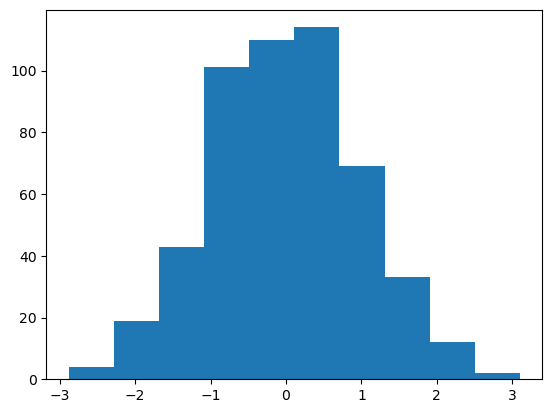

In [29]:
mpl.pyplot.hist(np.random.normal(size = mmodel.mean.size))


In [ ]:
self.std@ np.random.normal(size = self.mean.size)

(array([ 12.,  24.,  59.,  87., 106.,  91.,  62.,  45.,  13.,   8.]),
 array([-2.45643294, -1.94414437, -1.4318558 , -0.91956723, -0.40727866,
         0.10500991,  0.61729848,  1.12958705,  1.64187561,  2.15416418,
         2.66645275]),
 <BarContainer object of 10 artists>)

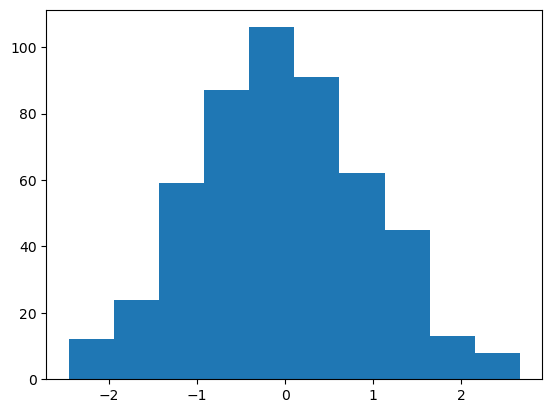

In [30]:
mpl.pyplot.hist(np.random.default_rng().normal(size = mmodel.mean.size))


In [14]:
clim1.X.loc[:,'S002',"F","Multi_Synthesis"].values

KeyError: "not all values found in index 'model'. Try setting the `method` keyword argument (example: method='nearest')."

In [12]:
clim3

In [47]:
clim_light_MM.X.loc[:,'S002',"F","Multi_Synthesis"].values

array([ -315685.29426026,    43612.15040269,    -6625.05170352,
         -96079.27460001,   310367.56000154,   527768.13704653,
        -127367.52025522,  -643883.98025824,   411406.13940072,
        -165461.25810763,  -220275.20395218,   265496.31125338,
         228746.71409079,   482184.38465033,  -172574.58395118,
        -280112.14320179,    43121.53007511,   194583.09745653,
         432967.11747395,  -234705.27104467,  -439438.47332469,
         145313.75797404,  -103686.68483316,  -642632.79959568,
          72328.94042466,  -163189.64661862,  -650465.17784826,
         180741.60656256,   661529.69828402,   213063.28814738,
         699718.36339549,  -242399.80224101,   178795.7952347 ,
          28087.14480748,  -319384.13863367,   425124.84842171,
        -327035.42192004,  -168123.92138825,   231005.70379367,
         270298.0887881 ,  -302994.72329783,  -401418.54567224,
         238874.50841871,  -298445.51571256,   257836.08336764,
        -609319.68617359,  -396344.78423

In [39]:
clim_CX.X.loc[:,'S000',"F","Multi_Synthesis"].values

array([ 9.67805957e+15, -8.56756739e+15, -4.92138001e+15, -4.04639022e+16,
       -1.96562561e+16,  1.82593880e+16,  3.90372221e+15,  6.65137296e+15,
        6.50070659e+15,  2.65647557e+16, -3.54801907e+16,  1.56334264e+16,
        4.90905178e+15,  3.66163690e+15, -7.14055272e+15,  2.55581630e+16,
       -1.60580207e+16,  1.14747438e+16, -5.05961206e+15, -2.20546767e+15,
       -2.38539858e+16, -1.02567846e+16,  2.53847510e+16, -1.98226074e+16,
        1.09374332e+16, -3.16172488e+15,  4.59889090e+16,  2.28760614e+15,
       -1.11054676e+16,  5.83812488e+15, -1.00422223e+15, -3.23424817e+16,
       -6.26976225e+14, -1.80674673e+14, -1.14125235e+16, -2.36074656e+16,
        6.50822716e+15, -1.97201135e+16,  2.10123223e+15,  4.48145875e+15,
        2.93434282e+16,  2.26956748e+16,  4.93834824e+14, -1.36571297e+16,
        1.53095498e+16,  3.67229407e+15, -8.54085805e+15,  1.09825185e+16,
       -2.46350549e+16, -1.49002171e+16, -1.33147576e+14,  7.62801037e+15,
        1.03108848e+16,  

In [24]:
1.60667173e+21

1.60667173e+21

In [34]:
clim_CX_Yoann.X.loc[:,'S00',"F","Multi_Synthesis"].values

array([-9.48479918e+21,  5.85922266e+20, -1.25841665e+21,  2.18522553e+22,
        5.58578678e+21,  3.99703145e+21,  1.85068006e+22, -6.90188274e+21,
        3.19655127e+21,  1.04223459e+21, -3.06515653e+21, -2.82209066e+21,
        5.89438423e+21,  4.20528649e+21, -1.35601571e+20,  4.52123847e+21,
       -1.20292301e+20,  1.70075594e+22, -1.27815495e+22,  1.00087495e+22,
       -2.30251401e+21, -1.73334202e+22, -6.42268596e+21, -7.37051618e+21,
       -3.95383661e+21,  6.06630355e+21, -1.20365232e+22,  1.46357652e+21,
        2.59489633e+21, -9.08124266e+21,  1.42983657e+21, -4.12647177e+21,
        4.98521519e+20,  5.22334988e+21,  7.54873508e+21,  1.28373066e+22,
       -7.11787042e+21,  2.53232635e+21, -8.42907023e+21, -7.38741061e+21,
        6.09397635e+21, -1.41306048e+22,  2.90217289e+21, -6.00288521e+21,
       -8.74450489e+21, -4.21787145e+20,  5.74633399e+21,  8.33731101e+21,
        2.09690518e+21, -4.42336118e+21,  2.69095774e+21,  5.75277649e+21,
       -3.17143817e+21,  

In [33]:
clim_CX_Yoann.sample

array(['BE', 'S00', 'S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07',
       'S08', 'S09'], dtype='<U3')

In [35]:
Xebm 

NameError: name 'Xebm' is not defined